# Assignment 5

**Assignment 5: Neuroevolution: Neural Architecture**

**Goal**: Get familiar with neural architecture search by applying an evolutionary algorithm to select the best architecture of a neural network.

## 1. Understanding the problem

In this assignment, we are going to use an evolutionary algorithm for selecting the best architecture of a neural network. As such, this assignment can be seen as a combination of assignment 3 and assignment 4. Similar to assignment 4, the neural network is trained on images.

In this task, **the code for a neural network must be implemented in PyTorch.**

## 2. Setup

In [1]:
import numpy as np
import torch
import torch.nn as nn
import scipy.stats as ss
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import load_digits

device = torch.device('cuda') # Use gpu for faster computations

### Dataset class
Used to generate different digits dataset objects

In [2]:
class Dataset_:
    class Digits(Dataset):
        def __init__(self, mode, transforms):
            self.digits = load_digits()
            if mode == 'train':
                self.data = self.digits.data[:1000].astype(np.float32)
                self.targets = self.digits.target[:1000]
            elif mode == 'val':
                self.data = self.digits.data[1000:1350].astype(np.float32)
                self.targets = self.digits.target[1000:1350]
            else:
                self.data = self.digits.data[1350:].astype(np.float32)
                self.targets = self.digits.target[1350:]
                
            self.transforms = transforms

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            sample_x = torch.from_numpy(self.data[idx].reshape(-1, 8, 8))
            sample_y = torch.tensor(self.targets[idx]).type(torch.LongTensor)
            if self.transforms:
                sample_x = self.transforms(sample_x)
            return sample_x.to(device), sample_y.to(device) # Port everything to chosen device
    
    def select_mode(self, mode, transforms=None):
        return self.Digits(mode, transforms)

### Phenotype expresser class
Used to convert a genotypes into a trainable and testable pytorch neural networks

In [3]:
class PhenotypeExpresser:
    class ClassifierNeuralNet(nn.Module):
        def __init__(self, classnet):
            super(PhenotypeExpresser.ClassifierNeuralNet, self).__init__()
            self.classnet = classnet
            self.nll = nn.NLLLoss(reduction='none')

        def classify(self, x):
            # Return the indices with the highest probability which
            # are equivalent to the class labels because the labels are digits
            return torch.argmax(self.classnet(x), axis=1)

        def forward(self, x, y, reduction='avg'):
            # Calculate the negative log likelihood loss based on the target values y
            # and how the classifier network classifies data x
            loss = self.nll(self.classnet(x), y)
            if reduction == 'sum':
                return loss.sum()
            return loss.mean()
    
    def __init__(self):
        # Activations and filters which are encoded in the genotype
        self._activations = [nn.ReLU(), nn.Sigmoid(), nn.Tanh(), nn.Softplus(), nn.ELU()]
        self._filters = [8, 16, 32]
    
    def __get_conv_layer(self, filters, structure):
        if structure: kernel, padding = 3, 1
        else: kernel, padding = 5, 2
        stride = 1
        return nn.Conv2d(1, self._filters[filters], kernel_size=kernel, padding=padding, stride=stride)
    
    @staticmethod
    def __get_pool_layer(kernel, avg_pool):
        kernel += 1
        return nn.AvgPool2d(kernel) if avg_pool else nn.MaxPool2d(kernel)
    
    def __get_input_size(self, filters, structure, kernel_pool):
        if structure: kernel, padding = 3, 1
        else: kernel, padding = 5, 2
        kernel_pool += 1
        return int(self._filters[filters]*((8-kernel+2*padding+1)/kernel_pool)**2)
    
    # Decode the genotype and return an object of a subclass of nn.Module
    def get_phenotype(self, genotype):
        classnet = nn.Sequential(
            self.__get_conv_layer(*genotype[:2]),
            self._activations[genotype[2]],
            self.__get_pool_layer(*genotype[3:5]),
            nn.Flatten(),
            nn.Linear(self.__get_input_size(*genotype[np.asarray([0,1,3])]), genotype[5]*10),
            self._activations[genotype[2]],
            nn.Linear(genotype[5]*10, 10),
            nn.LogSoftmax(dim=1)).to(device)
        return self.ClassifierNeuralNet(classnet)
    
    def get_phenotypes(self, genotypes):
        phenotypes = []
        for genotype in genotypes:
            phenotype = self.get_phenotype(genotype)
            phenotypes.append(phenotype)
        return np.asarray(phenotypes)
            

### Evaluator class
Used to provide the objective function to the evolutionary algorithm

In [4]:
class Evaluator:
    def __init__(self, epochs=50, lr=1e-3, wd=1e-4):
        self.PE = PhenotypeExpresser()
        dataset = Dataset_()
        [train, val, test] = [dataset.select_mode(mode) for mode in ['train', 'val', 'test']]
        # Create a laoder for every type of data
        self.training_loader = DataLoader(train, batch_size=64, shuffle=True)
        self.val_loader = DataLoader(val, batch_size=64, shuffle=False)
        self.test_loader = DataLoader(test, batch_size=64, shuffle=False)
        # Hyperparameters used in neural network training
        self.epochs = epochs
        self.lr = lr
        self.wd = wd
    
    # Get the test/validation loss and classification error
    def test(self, model, test_loader):
        model.eval()
        loss_test = 0.
        loss_error = 0.
        N = 0.
        
        # start evaluation
        for indx_batch, (test_batch, test_targets) in enumerate(test_loader):
            # Classification loss
            loss_test_batch = model.forward(test_batch, test_targets, reduction='sum')
            loss_test = loss_test + loss_test_batch.item()
            
            # classification error
            y_pred = model.classify(test_batch)
            e = 1.*(y_pred == test_targets)
            loss_error = loss_error + (1. - e).sum().item()
            
            # the number of examples
            N = N + test_batch.shape[0]
        
        # Calculate average loss and error rate
        loss_test = loss_test / N
        loss_error = loss_error / N

        return loss_test, loss_error
    
    # Train a pytorch model
    def train(self, model, optimizer):
        model.train()
        # Main training loop
        for e in range(self.epochs):
            for indx_batch, (batch, targets) in enumerate(self.training_loader):
                loss = model.forward(batch, targets)
                optimizer.zero_grad()
                loss.backward(retain_graph=True)
                optimizer.step()
        return model
    
    def evaluate(self, x, validation_num=5, test=False):
        f = np.zeros(x.shape[0])
        # Run multiple times to improve consistency of evaluation
        for _ in range(validation_num):
            # Create the neural network models
            models = self.PE.get_phenotypes(x.reshape(-1, 6))
            # For each model, train it and evaluate it
            for i, model in enumerate(models):
                optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad],
                                             lr=self.lr, weight_decay=self.wd) 
                model = self.train(model, optimizer)
                _, error = self.test(model, self.val_loader if not test else self.test_loader)
                # Add all evaluations from the same model together
                f[i] += error
        # Return average classification errors
        return f/validation_num



### Evolutionary algorithm class
Uses crossover and mutation to create new individuals from old ones and steadily improves the population with new best fitting individuals

In [5]:
class EA:
    def __init__(self, evaluator, pop_size, bounds_min, bounds_max, std=1, parents=None):
        self.evaluator = evaluator
        self.pop_size = pop_size
        self.parents = parents if parents is not None else pop_size
        self.std = std
        self.bounds_min = bounds_min
        self.bounds_max = bounds_max
    
    # Select and return a random number of parents equal to parents hyperparameter
    def parent_selection(self, x_old, f_old):
        ind = np.random.choice(self.pop_size, self.parents, replace=False)
        return x_old[ind], f_old[ind]
    
    # Combine random part of parent i with the remaining part of random parent j to create child i
    def recombination(self, x_parents, f_parents):
        x_children = []
        for i in range(self.pop_size):
            j = np.random.randint(x_parents.shape[0])
            cutoff = np.random.randint(x_parents.shape[1])
            x_children.append(np.concatenate([x_parents[i%self.parents][:cutoff], x_parents[j][cutoff:]]))
        return np.asarray(x_children)
    
    # Mutate the different types of 'genes' with corresponding methods
    def mutation(self, x_children):
        binary_mutation = np.random.binomial(1, 0.2, (x_children.shape[0], 3))
        integer_mutation = np.random.binomial(1, 0.2, (x_children.shape[0], 2)) \
                           * np.round(np.random.normal(0, self.std, size=(x_children.shape[0], 2)))
        categorical_mutation = np.random.randint(5, size=x_children.shape[0])
        
        x_children[:,np.array([1, 3, 4])] = (x_children[:,np.array([1, 3, 4])] + binary_mutation)%2 # Flipping bits
        x_children[:,np.array([0, 5])] = x_children[:,np.array([0, 5])] + integer_mutation # Creep mutation
        x_children[:,2] = categorical_mutation # Mutation for activation function

        return np.clip(x_children, self.bounds_min, self.bounds_max)
    
    # Elitist survival selection
    def survivor_selection(self, x_old, x_children, f_old, f_children):
        x = np.concatenate([x_old, x_children])
        f = np.concatenate([f_old, f_children])
        
        ind = np.argsort(f)
        x = x[ind]
        f = f[ind]
        
        return x[:self.pop_size], f[:self.pop_size]

    def evaluate(self, x):
        return self.evaluator.evaluate(x)
  
    def step(self, x_old, f_old):
        x_parents, f_parents = self.parent_selection(x_old, f_old)
        x_children = self.recombination(x_parents, f_parents)
        x_children = self.mutation(x_children)
        f_children = self.evaluate(x_children)
        x, f = self.survivor_selection(x_old, x_children, f_old, f_children)
                       
        return x, f

## 3. Running the algorithm

In [6]:
# --------------HYPERPARAMETERS--------------
num_generations = 20
pop_size = 20
bounds_min = np.asarray([0, 0, 0, 0, 0, 1])
bounds_max = np.asarray([2, 1, 4, 1, 1, 10])

# --------------EA OBJECT--------------
e = Evaluator(epochs=5)
ea = EA(e, pop_size, bounds_min, bounds_max)

# --------------INITIAL POPULATION--------------
x = np.random.randint(low=bounds_min, high=bounds_max+1, size=(pop_size, 6))
f = e.evaluate(x)

populations = []
populations.append(x)
f_best = [f.min()]

# --------------OPTIMIZATION--------------
for i in range(num_generations):
    if i % int(num_generations * 0.1) == 0:
        print('Generation: {}, best fitness: {:.3f}'.format(i, f.min()))
    x, f = ea.step(x, f)
    populations.append(x)
    if f.min() < f_best[-1]:
        f_best.append(f.min())
    else:
        f_best.append(f_best[-1])
print('FINISHED!')

# --------------FINAL EVALUATION--------------
test_ce = e.evaluate(x[f.argmin()], test=True)[0]
print(f'Final best fitness: {test_ce:.3}')

Generation: 0, best fitness: 0.033
Generation: 2, best fitness: 0.029
Generation: 4, best fitness: 0.029
Generation: 6, best fitness: 0.026
Generation: 8, best fitness: 0.025
Generation: 10, best fitness: 0.025
Generation: 12, best fitness: 0.025
Generation: 14, best fitness: 0.025
Generation: 16, best fitness: 0.023
Generation: 18, best fitness: 0.023
FINISHED!
Final best fitness: 0.0931


## 4. Analysis

### Attribute scatter plots

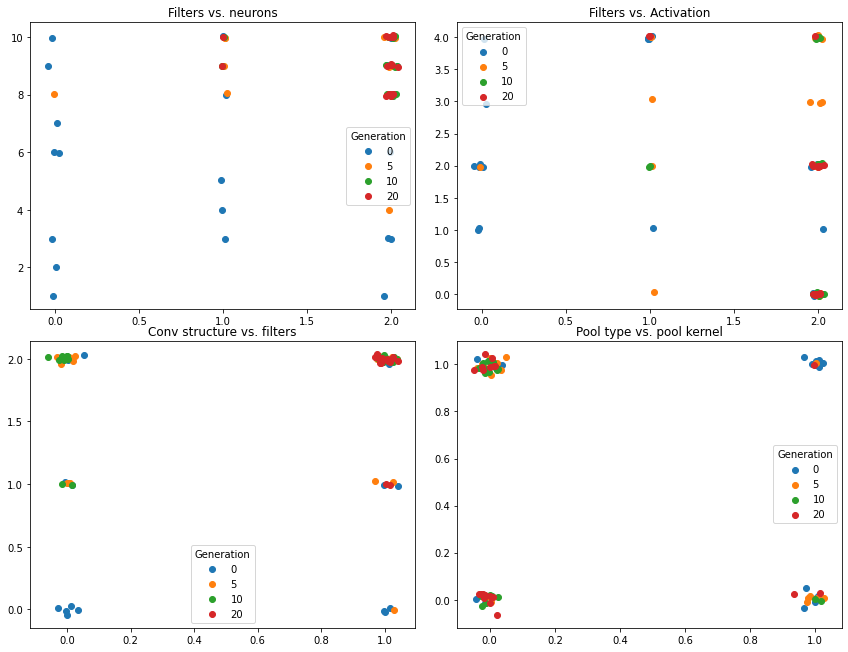

In [7]:
gens = [0, num_generations//4, num_generations//2, num_generations]
fig_ea_pops, axs = plt.subplots(2, 2, figsize=(12, 9))
fig_ea_pops.tight_layout()

for i in range(len(gens)):
    pop_i = populations[gens[i]] + np.random.randn(*populations[gens[i]].shape)/50
    axs[0,0].scatter(pop_i[:,0], pop_i[:,-1], label=str(gens[i]))
    axs[0,1].scatter(pop_i[:,0], pop_i[:,2], label=str(gens[i]))
    axs[1,0].scatter(pop_i[:,1], pop_i[:,0], label=str(gens[i]))
    axs[1,1].scatter(pop_i[:,3], pop_i[:,4], label=str(gens[i]))
axs[0,0].legend(title='Generation'), axs[0,1].legend(title='Generation'), axs[1,0].legend(title='Generation'), axs[1,1].legend(title='Generation')
axs[0,0].set_title('Filters vs. neurons')
axs[0,1].set_title('Filters vs. Activation')
axs[1,0].set_title('Conv structure vs. filters')
axs[1,1].set_title('Pool type vs. pool kernel')

plt.show()

### Convergence

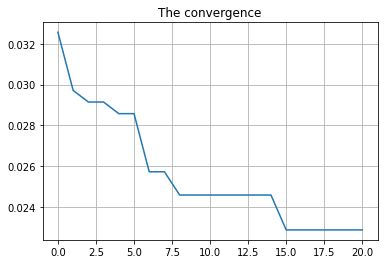

In [8]:
plt.plot(range(len(f_best)), f_best)
plt.title('The convergence')
plt.grid()

### Best neural network

In [9]:
model = e.PE.get_phenotype(x[f.argmin()])
optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad], lr=e.lr, weight_decay=e.wd) 
val_loss, val_error = [], []

model.train()
for _ in range(50):
    for indx_batch, (batch, targets) in enumerate(e.training_loader):
        loss = model.forward(batch, targets)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
    loss, error = e.test(model, e.val_loader)
    val_loss.append(loss)
    val_error.append(error)
loss, error = e.test(model, e.test_loader)

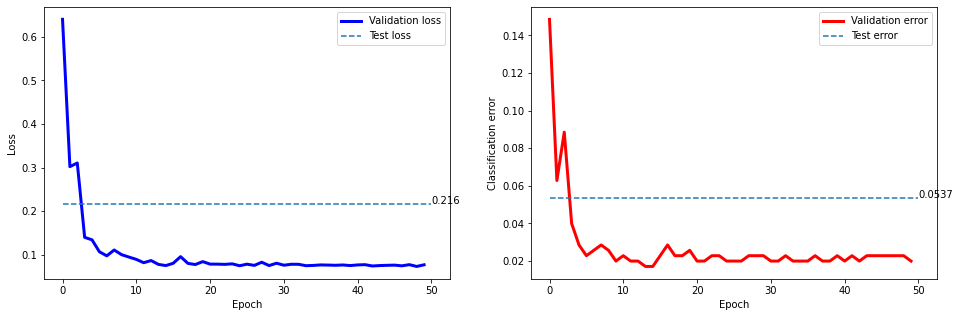

In [10]:
_, axs = plt.subplots(1, 2, figsize=(16, 5))
axs[0].plot(range(len(val_loss)), val_loss, color='blue', linewidth='3', label='Validation loss')
axs[1].plot(range(len(val_error)), val_error, color='red', linewidth='3', label='Validation error')

axs[0].hlines(loss, xmin=0, xmax=len(val_loss), linestyles='dashed', label='Test loss')
axs[0].text(len(val_loss), loss, f"{loss:.3}")
axs[1].hlines(error, xmin=0, xmax=len(val_loss), linestyles='dashed', label='Test error')
axs[1].text(len(val_loss), error, f"{error:.3}")

axs[0].set_xlabel('Epoch'), axs[0].set_ylabel('Loss')
axs[1].set_xlabel('Epoch'), axs[1].set_ylabel('Classification error')
axs[0].legend()
axs[1].legend()

plt.show()